In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sympy as sp
sp.init_printing()
import bayesian_pdes as bpdes
import matplotlib
from mcmc import pcn
%load_ext mcmc
%mcmc notebook
from scipy import stats
#import gpanim
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.unicode'] = True

In [2]:
class NamedLambda(object):
    def __init__(self, func, desc):
        self.__func__ = func
        self.__desc__ = desc
    def __call__(self, *args):
        return self.__func__(*args)
    def __str__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)
    def __repr__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)

In [3]:
seed = 124
np.random.seed(seed)

In [4]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')

In [5]:
# load in observational data
current_file = np.loadtxt('RPI_2d_chest_phantom_data/ssout1.dat')
voltage_file_targets = np.loadtxt('RPI_2d_chest_phantom_data/ACT2000r.txt')
voltage_file_empty = np.loadtxt('RPI_2d_chest_phantom_data/ACT2006r.txt')
voltage_file_targets_quad = np.loadtxt('RPI_2d_chest_phantom_data/ACT2000q.txt')
voltage_file_empty_quad = np.loadtxt('RPI_2d_chest_phantom_data/ACT2006q.txt')


experiments = []
quadratures = []
for i in range(len(current_file) / 32):
    this_currents = current_file[32*i:32*(i+1)]
    this_voltages_targets = voltage_file_targets[32*i+1:32*(i+1)+1]
    this_voltages_empty = voltage_file_empty[32*i+1:32*(i+1)+1]
    this_voltages_targets_quad = voltage_file_targets_quad[32*i+1:32*(i+1)+1]
    this_voltages_empty_quad = voltage_file_empty_quad[32*i+1:32*(i+1)+1]
    experiments.append((this_currents.reshape((32,1)), this_voltages_targets.reshape((32,1)), this_voltages_empty.reshape((32,1))))
    quadratures.append((this_voltages_targets_quad.reshape((32,1)), this_voltages_empty_quad.reshape((32,1))))

In [6]:
length_scale = 0.1
k_sqexp = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale**2))

# Operators in the expanded version of the problem
A_1 = NamedLambda(lambda k: k.diff(x_1), 'A_1')
A_2 = NamedLambda(lambda k: k.diff(x_2), 'A_2')
A_3 = NamedLambda(lambda k: k.diff(x_1, x_1) + k.diff(x_2, x_2), 'A_3')
A_1_bar = NamedLambda(lambda k: k.diff(y_1), 'A_1_bar')
A_2_bar = NamedLambda(lambda k: k.diff(y_2), 'A_2_bar')
A_3_bar = NamedLambda(lambda k: k.diff(y_1, y_1) + k.diff(y_2, y_2), 'A_3_bar')

# Transformed operators
A_t = 'A_t'
A_bar_t = 'A_bar_t'

# Boundary operators
B = NamedLambda(lambda k: (k.diff(x_1)*x_1 + k.diff(x_2)*x_2), 'B')
B_bar = NamedLambda(lambda k: (k.diff(y_1)*y_1 + k.diff(y_2)*y_2), 'B_bar')

# Transformed boundary operators
B_t = 'B_t'
B_bar_t = 'B_bar_t'

ops_base = [A_1, A_2, A_3, B]
ops_bar_base = [A_1_bar, A_2_bar, A_3_bar, B_bar]
op_cache_base = bpdes.operator_caching.generate_op_cache(ops_base, ops_bar_base, k_sqexp, [[x_1, x_2], [y_1, y_2]])

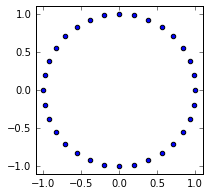

In [7]:
# there are 32 evenly spaced electrodes between 0 and 2\pi
# the electrodes go counter-clockwise from the +x axis and finish at x=1, y=0
electrodes = np.linspace(0, 2*np.pi, 33)[1:-1]
electrodes = np.append(electrodes,0)
electrode_x = np.cos(electrodes)
electrode_y = np.sin(electrodes)
plt.figure(figsize=(3,3))
plt.scatter(electrode_x, electrode_y)
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

bdy = np.c_[electrode_x, electrode_y]

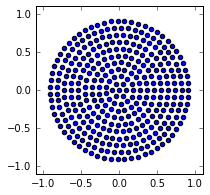

In [8]:
# we also need a few interior points
radii = np.linspace(0,1,12)[1:-1]
r_spacing = radii[1] - radii[0]
coords = [np.array([[0.,0.]])]
for r in radii:
    # we want the number of theta which 
    n_theta = np.round(2*np.pi*r / r_spacing)
    thetas = np.linspace(0, 2*np.pi, n_theta+1)[:-1]
    x = np.cos(thetas)
    y = np.sin(thetas)
    coords.append(r*np.c_[x,y])
coords = np.concatenate(coords)

plt.figure(figsize=(3,3))
plt.scatter(coords[:,0], coords[:,1])
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

interior = coords

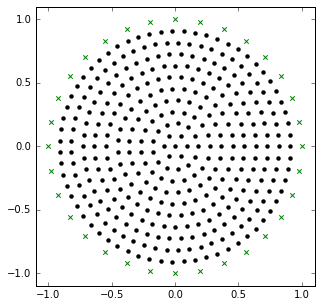

In [9]:
plt.figure(figsize=(5,5))
plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
plt.scatter(bdy[:,0], bdy[:,1], marker='x', c='green')
plt.scatter(interior[:,0], interior[:,1], linewidth=0, c='black')

In [10]:
field_pts = np.r_[interior, bdy]
n_field = len(field_pts)
def vec_to_kappas(vec):
    return vec[:n_field, None], vec[n_field:2*n_field, None], vec[2*n_field:, None]

In [11]:
arg_caching = bpdes.operator_caching.CachingOpCache(op_cache_base)

In [12]:
from __future__ import print_function
class TransformedOpCache(object):
    def __init__(self, op_cache, kappa, grad_kappa_x, grad_kappa_y, verbosity=0):
        self.__op_cache__ = op_cache
        self.__kappa__ = kappa
        self.__grad_kappa_x__ = grad_kappa_x
        self.__grad_kappa_y__ = grad_kappa_y
        self.__verbosity__ = verbosity
    
    def __getitem__(self, item):
        return do_transform(item, self.__op_cache__, self.__kappa__, self.__grad_kappa_x__, self.__grad_kappa_y__, self.__verbosity__)

def do_transform(item, op_cache, kappa, grad_kappa_x, grad_kappa_y, verbosity):
    def printer(*args):
        if verbosity > 0:
            print(*args)
    exp_kappa = np.exp(kappa.reshape((len(kappa), 1)))
    exp_kappa_int = exp_kappa[:len(interior),:]
    exp_kappa_bdy = exp_kappa[len(interior):,:]
    grad_kappa_x = grad_kappa_x[:len(interior)].reshape((len(interior),1))
    grad_kappa_y = grad_kappa_y[:len(interior)].reshape((len(interior),1))
    all_things = [()]
    
    # first explode out the objects required
    for i in item:
        if i == A_t:
            all_things = sum([[a + (A_1,), a + (A_2,), a + (A_3,)] for a in all_things], [])
        elif i == A_bar_t:
            all_things = sum([[a + (A_1_bar,), a + (A_2_bar,), a + (A_3_bar,)] for a in all_things], [])
        elif i == B_t:
            all_things = [a + (B,) for a in all_things]
        elif i == B_bar_t:
            all_things = [a + (B_bar,) for a in all_things]
        else:
            all_things = [a + (i,) for a in all_things]
    printer(all_things)

    def __calc_result(x,y):
        result = 0
        for item in all_things:
            try:
                function = op_cache[item]
            except Exception as ex:
                printer('Failed to get {}'.format(item))
                raise ex
            new_mat = function(x,y)
            if A_1 in item:
                printer('A_1')
                new_mat = np.repeat(grad_kappa_x*exp_kappa_int,y.shape[0],1) * new_mat
            if A_2 in item:
                printer('A_2')
                new_mat = np.repeat(grad_kappa_y*exp_kappa_int,y.shape[0],1) * new_mat
            elif A_3 in item:
                printer('A_3')
                new_mat = np.repeat(exp_kappa_int,y.shape[0],1) * new_mat
            if A_1_bar in item:
                printer('A_1_bar')
                new_mat = np.repeat(grad_kappa_x.T*exp_kappa_int.T,x.shape[0],0) * new_mat
            if A_2_bar in item:
                printer('A_2_bar')
                new_mat = np.repeat(grad_kappa_y.T*exp_kappa_int.T,x.shape[0],0) * new_mat
            elif A_3_bar in item:
                printer('A_3_bar')
                new_mat = np.repeat(exp_kappa_int.T,x.shape[0],0) * new_mat
            elif B in item:
                new_mat = np.repeat(exp_kappa_bdy, y.shape[0], 1) * new_mat
            elif B_bar in item:
                new_mat = np.repeat(exp_kappa_bdy.T, x.shape[0], 0) * new_mat
            result += new_mat
        return result
    return __calc_result

In [13]:
from bayesian_pdes.problems import problem_helpers, eit
eit_computer = eit.FastEITMatrixComputer(interior, bdy, field_pts, k_sqexp, [[x_1, x_2], [y_1, y_2]])

In [14]:
kappa = np.zeros(n_field)
grad_kappa_x = np.zeros(n_field)
grad_kappa_y = np.zeros(n_field)
true = eit_computer.AAbar(kappa, grad_kappa_x, grad_kappa_y)
oc = TransformedOpCache(arg_caching, kappa, grad_kappa_x, grad_kappa_y)
tmp = oc[(A_t, A_bar_t)](interior, interior)

In [15]:
np.testing.assert_almost_equal(true, tmp)

In [16]:


ops = [A_t, B_t]
ops_bar = [A_bar_t, B_bar_t]

In [17]:
# so the PDE is zero in the interior...
interior_obs = np.zeros((interior.shape[0], 1))

# and on the boundary we apply a charge...
experiment = 10
currents, voltages_target, voltages_empty = experiments[experiment]

obs = [
    (interior, interior_obs),
    (bdy, voltages_target)
]

In [18]:
tp = [np.array([[0.,0.]])]
radii = np.linspace(0,1,21)[1:]

for r in radii:
    n_theta = np.round(2*np.pi*r / 0.1)
    theta = np.linspace(0,2*np.pi,n_theta)
    tp.append(r*np.c_[np.cos(theta), np.sin(theta)])
test_pts = np.concatenate(tp)

In [19]:
oc = TransformedOpCache(op_cache_base, np.zeros(n_field), np.zeros(n_field), np.zeros(n_field))
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc)

In [20]:
mu, Sigma = posterior(test_pts)

In [21]:
def plot_conductivity(thetas):
    sig_expr = get_c(x_1, x_2).subs({t: v for t,v in zip(ts, thetas)})
    sigma_field = sp.lambdify([x_1, x_2], sig_expr)
    res = np.vectorize(sigma_field)(test_x, test_y)
    plot_circle(test_x, test_y, res)
    
def plot_circle(x, y, values):
    plt.figure(figsize=(8,8))
    plt.tripcolor(x.ravel(), y.ravel(), values.ravel())
    #colors = plt.contourf(test_x, test_y, mu_shaped,  250)
    plt.colorbar()
    plt.scatter(interior[:,0], interior[:,1],  marker='x', c='black', s=50, label='Interior Points')
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);
    plt.gcf().patch.set_alpha(0.0)

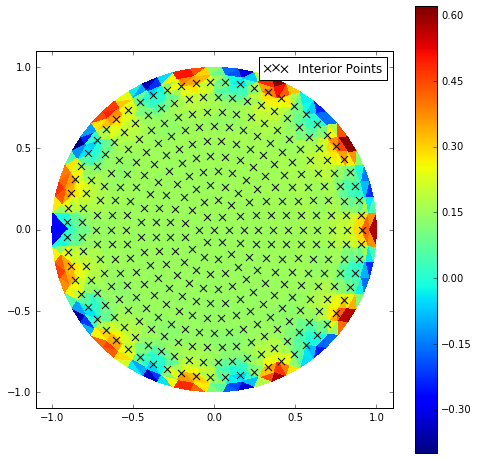

In [22]:
plot_circle(test_pts[:,0], test_pts[:,1], mu)

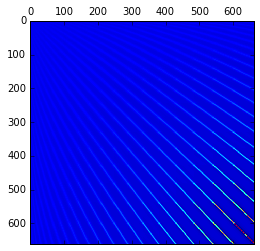

In [23]:
plt.matshow(Sigma)

In [24]:
# now need to construct the thingy we are proposing over.
# Put a basis function at each point in the domain and iterate over them
proposal_length_scale = 0.1
k_proposal = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*proposal_length_scale**2)) 

# jointly proposing over the function and its derivatives wrt x and y.
# ironically constructing this is very similar to constructing our kernel matrix
Identity = lambda k: k
d1 = lambda k: k.diff(x_1)
d2 = lambda k: k.diff(x_2)
d1_bar = lambda k: k.diff(y_1)
d2_bar = lambda k: k.diff(y_2)

proposal_obs = [
    (field_pts, None),
    (field_pts, None),
    (field_pts, None)
]

proposal_op_cache = bpdes.operator_caching.generate_op_cache([Identity, d1, d2], [Identity, d1_bar, d2_bar], k_sqexp, [[x_1, x_2], [y_1, y_2]])
kern_mat = bpdes.collocation.calc_LLbar([Identity, d1, d2], [Identity, d1_bar, d2_bar], proposal_obs, proposal_op_cache)

In [25]:
new = np.random.multivariate_normal(np.zeros(kern_mat.shape[0]), kern_mat)

In [26]:
k, k_x, k_y = vec_to_kappas(new)
oc = TransformedOpCache(arg_caching, k, k_x, k_y)
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc) 
mu_1, _ = posterior(test_pts)

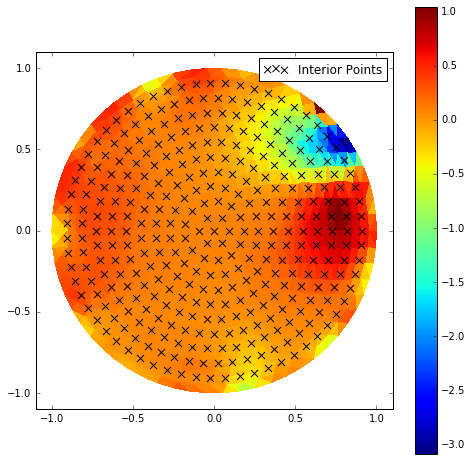

In [27]:
plot_circle(test_pts[:,0], test_pts[:,1], mu_1)

In [39]:
# is there a units issue with normalising voltage here?
true_x = bdy
#kappa_0 = np.zeros((n_field*3, 1))
#currents = [e[0] for e in experiments]
#voltages = [e[1] for e in experiments]
#volt_mean = np.asarray(voltages).mean()
#volt_std = np.asarray(voltages).std()

kappa_0 = true_fun
currents = true_currents
voltages = true_voltages
volt_mean = 0.
volt_std = 1.

In [40]:

def potential(proposal):
    # potential is the negative log-likelihood
    return -log_likelihood(proposal)
def log_likelihood(proposal):
    # ugly and dirty and horrid
    kappa, kappa_x, kappa_y = vec_to_kappas(proposal)
    
    oc = TransformedOpCache(arg_caching, kappa, kappa_x, kappa_y)
    #oc = op_cache
    
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc)
    mu_mult, cov = posterior.no_obs_posterior(true_x)
    cov_with_error = cov + likelihood_sigma**2*np.eye(cov.shape[0])
    
    
    cov_with_error_inv = np.linalg.inv(cov_with_error)
    cov_with_error_det = np.linalg.det(cov_with_error)
    #if np.isnan(np.log(cov_with_error_det)):
    #    raise Exception('Log-determinant is NaN')
    
    #print(np.linalg.cond(cov_with_error), cov_with_error_det)
    #plt.matshow(cov_with_error); plt.colorbar()
    
    ret = 0
    for c, v in zip(currents, voltages):
        g = np.concatenate([interior_obs, c])
        true_u = (v.ravel() - volt_mean) / volt_std
        true_u = true_u.reshape((len(true_u), 1))
        mu = mu_mult.dot(g).reshape(true_u.shape)
        
        # todo: some inefficiency here - inverting cov multiple times
        #this_lik = stats.multivariate_normal.logpdf(true_u.ravel(), mu.ravel(), cov_with_error, False)
        #this_lik = -(mu-true_u).T.dot(cov_with_error_inv).dot(mu-true_u) - 0.5*np.log(cov_with_error_det)
        this_lik = -(mu - true_u).T.dot(mu - true_u) / (2*likelihood_sigma**2)
        #print np.mean(true_u - mu), this_lik
        ret += this_lik
    return ret

In [41]:
likelihood_sigma = 1e-2

In [44]:
reload(pcn)
beta = 1e-3
propose = pcn.proposal(beta, kern_mat) 
adapt_function = pcn.adapt_function(1000, 0.2, 0.5, 2.0, 1)
kappas = pcn.pCN(int(1e5), propose, potential, true_fun)

KeyboardInterrupt: 

In [604]:
#print acceptances.sum() * 1./iterations
thin= 1
burn = 50000
max = -1
thinned_burned = kappas[burn:max:thin, :]
#plt.legend(loc=2, bbox_to_anchor=(1.05,1))

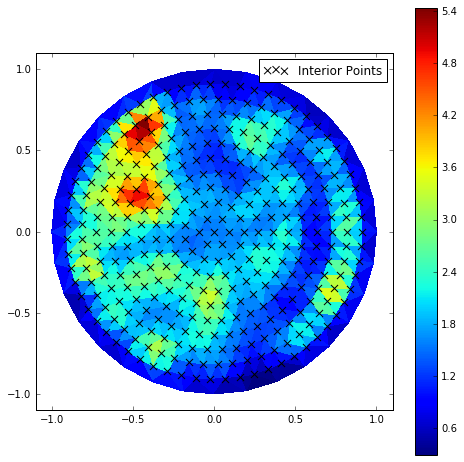

In [605]:
actual = np.mean(thinned_burned, axis=0)

plot_circle(field_pts[:,0], field_pts[:,1], np.exp(actual[:len(field_pts)]))

In [627]:
log_likelihood(kappas[-1,:])

array([[-3619456.27449099]])

In [628]:
log_likelihood(true_fun)

array([[-4772623.98984339]])

# attempt to make a dummy diffusivity field

In [32]:
true_kappa = 5*sp.exp(-((x_1 - 0.5)**2 + (0.5*x_2 + 0.1)**2) / (2*0.2**2)) + 5*sp.exp(-((x_1 + 0.5)**2 + (0.5*x_2 + 0.1)**2) / (2*0.2**2)) +  \
                5*sp.exp(-((x_1)**2 + (x_2-0.5)**2)/(2*0.2**2))
true_kappa_dx1 = true_kappa.diff(x_1)
true_kappa_dx2 = true_kappa.diff(x_2)

true_kappa_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa))
true_kappa_dx1_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx1))
true_kappa_dx2_fun = np.vectorize(sp.lambdify([x_1, x_2], true_kappa_dx2))

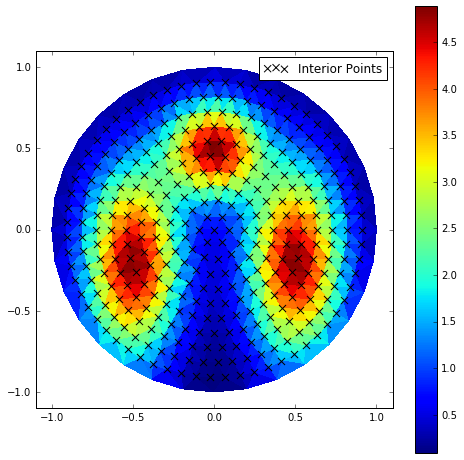

In [33]:
plot_circle(field_pts[:,0], field_pts[:,1], true_kappa_fun(field_pts[:,0], field_pts[:,1]))

In [34]:
true_k = true_kappa_fun(field_pts[:,0], field_pts[:,1])
true_k_x = true_kappa_dx1_fun(field_pts[:,0], field_pts[:,1])
true_k_y = true_kappa_dx2_fun(field_pts[:,0], field_pts[:,1])
true_fun = np.r_[true_k, true_k_x, true_k_y]

In [35]:
noise_variance = 1e-2
true_currents = [e[0] for e in experiments]
true_voltages = []
oc = TransformedOpCache(op_cache_base, true_k, true_k_x, true_k_y)
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc)
mu_mult, cov = posterior.no_obs_posterior(true_x)
for c in true_currents:
    g = np.concatenate([interior_obs, c])
    mu = mu_mult.dot(g) + np.random.normal(size=(mu_mult.shape[0], 1)) * noise_variance
    true_voltages.append(mu)

In [36]:
tmp_obs = [(interior, interior_obs), (bdy, c)]
posterior = bpdes.collocate(ops, ops_bar, None, None, tmp_obs, oc)
mu, cov = posterior(np.c_[np.linspace(0,1,21), np.zeros(21)])

7409978.06843


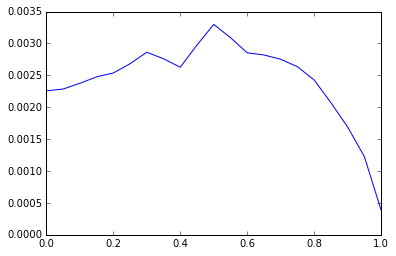

In [37]:
plt.plot(np.linspace(0,1,21),mu)
cov_cond = np.linalg.cond(cov)
print(cov_cond)

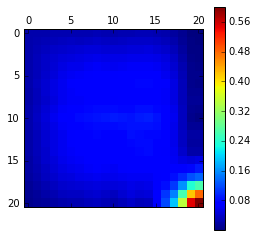

In [38]:
plt.matshow(cov); plt.colorbar()